# Train language model

In [1]:
from fastai.text import *

In [2]:
path = Path('/mnt/hdd1/data/jigsaw-unintended-bias-in-toxicity-classification')
# path = Path('/home/tony/Documents/jigsaw-unintended-bias-in-toxicity-classification')

# Initializing language model data

### Load csv

In [6]:
train_df = pd.read_csv(path/'train.csv')

In [7]:
valid_df = pd.read_csv(path/'test.csv')

### Look at the data

In [ ]:
train_df

### Using data bunch

In [6]:
# data_lm = TextDataBunch.from_df(path, train_df, valid_df, text_cols='comment_text')
data_lm = TextLMDataBunch.from_csv(path, 'train.csv', text_cols='comment_text')

In [7]:
data_lm.save(path/'language_model.pkl')

# Prepare to train language model

## Setup model

In [3]:
bs=44

In [4]:
data_lm = load_data(path, 'language_model.pkl', bs=bs)

### AWD_LSTM

In [5]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3).to_fp16()

### Transformer

In [5]:
learn = language_model_learner(data_lm, Transformer, drop_mult=0.3).to_fp16()

### TransformerXL

In [5]:
learn = language_model_learner(data_lm, TransformerXL, drop_mult=0.05).to_fp16()

/home/tony/anaconda3/envs/pytorch/lib/python3.7/site-packages/fastai/text/learner.py:214: UserWarning: There are no pretrained weights for that architecture yet!
  warn("There are no pretrained weights for that architecture yet!")


## Load data and save

In [6]:
learn = learn.load('transformerXL_fit')

In [14]:
learn.save('transformerXL_fit')

In [7]:
learn.save_encoder('transformerXL_enc')

# Finding learning rate

In [7]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


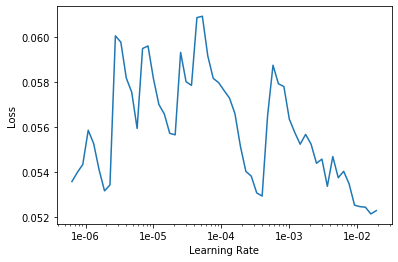

In [8]:
learn.recorder.plot(skip_end=15)

# Train language model

In [10]:
learn.unfreeze()

In [23]:
learn.freeze_to(-3)

In [13]:
learn.fit_one_cycle(5, 1e-6, moms=(0.4,0.3))

epoch,train_loss,valid_loss,accuracy,time
0,3.894605,3.940924,0.318457,3:23:57
1,3.902385,3.939356,0.318659,3:24:03
2,3.900538,3.937201,0.318841,3:23:59
3,3.913884,3.936241,0.318946,3:24:01
4,3.885344,3.935934,0.318969,3:24:10


# Initializing regression data

## Create regression dataset

In [17]:
data_lm.vocab.save(path/'vocab.vc')

In [3]:
vocab = Vocab.load(path/'vocab.vc')

In [10]:
data_reg = (TextList.from_csv(path, 'train.csv', vocab=vocab, cols='comment_text')
           .split_by_rand_pct(0.2)
           .label_from_df(cols='target', label_cls=FloatList)
           .databunch())

In [13]:
data_reg.save(path/'data_reg.pkl')

# Prepare to train regression model

## Setup data

In [3]:
bs=16

In [4]:
data_reg = load_data(path, 'data_reg.pkl', bs=bs)

### TransformerXL

In [5]:
learn = text_classifier_learner(data_reg, TransformerXL, drop_mult=0.15).to_fp16()

/home/tony/anaconda3/envs/pytorch/lib/python3.7/site-packages/fastai/text/learner.py:297: UserWarning: There are no pretrained weights for that architecture yet!
  warn("There are no pretrained weights for that architecture yet!")


## Load and save data

In [6]:
learn.load_encoder('transformerXL_enc')

In [6]:
learn = learn.load('transformerXL_reg')

In [12]:
learn.save('transformerXL_reg')

# Train regression model

In [ ]:
learn.unfreeze()

In [ ]:
learn.freeze_to(-2)

In [ ]:
learn.fit_one_cycle(1, 1e-4, moms=(0.8,0.7))

epoch,train_loss,valid_loss,time
